In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#pip install ydata-profiling
# from ydata_profiling import ProfileReport

warnings.filterwarnings('ignore')

# Importando base de dados
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Populating the interactive namespace from numpy and matplotlib


In [221]:
# profile_report = ProfileReport(train, title='Titanic Report')
# profile_report.to_file('Titanic_Report.html')

In [222]:
def clean_data(data):
  # Passo 1
  # Eliminar colunas com menos de 50% de valores preenchidos
  col_drop = data.columns[(data.isnull().sum()/data.shape[0]) > 0.5]
  data.drop(col_drop, inplace=True, axis=1)

  # Passo 2
  # Tratar aa colunas Age e Fare separadamente pois são as únicas que iremos popular os NaNs com a média
  if(data['Age'].isnull().sum() > 0):
    data.Age.fillna(data['Age'].mean(), inplace=True)
    data.Fare.fillna(data['Fare'].mean(), inplace=True)
    data.Embarked.fillna(data['Embarked'].mode(), inplace=True)

  # Passo 3
  # Criar coluna de title para saber a hierarquia das pessoas
  data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
  for n in data['Title']:
    if n in ['Mr', 'Miss', 'Mrs', 'Master', 'Col', 'Major', 'Dr', 'Rev', 'Mlle']:
      data['Title'] = n
    else:
      data['Title'] = 'Outros'

  data.drop(['Name', 'Ticket'], inplace=True, axis=1)

  # Passo 4
  # Transformando valores texto em numéricos
  le = preprocessing.LabelEncoder()
  cols = ['Sex', 'Embarked', 'Title']
  for col in cols:
    data[col] = le.fit_transform(data[col])
    # print(le.classes_)

  return data

# Chamar função para limpeza das bases de treino e teste
train = clean_data(train)
test = clean_data(test)

In [223]:
# # Limpando o texto da coluna Ticket para colocar no modelo
# str_drop = ['A/5 ', 'A.5. ','A/4 ','A/S ','A4. ','C ','C.A. ','C.A./SOTON ','CA','CA. ','F.C. ','F.C.C. ','Fa ','LINE','P/PP ','PC ','PP ','S.C./A.4. ','S.C./PARIS ','S.O./P.P. ',
# 'S.O.C. ','S.O.P. ','S.P. ','S.W./PP ','SC ','SC/AH ','SC/AH Basle ','SC/Paris ','SC/PARIS ','SCO/W ','SO/C ','SOTON/O.Q. ','SOTON/O2 ', 'STON/O2. ','SOTON/OQ ','SW/PP ',
# 'STON/O 2. ','W./C. ','W.E.P. ','W/C ','WE/P ', 'P', 'A/5. ', 'A./5. ', 'A/4. ', '',' ', '  ', '   ', 'SO/', '. ', '.', 'Basle', 'W/', 'SW/', 'S', 'SW/', 'C/A', 'TON/OQ',
# 'C/A', 'AQ/', 'A', 'L', 'AQ/']

# for value in str_drop:
#   train['Ticket'] = train['Ticket'].str.replace(value, '')
#   test['Ticket'] = test['Ticket'].str.replace(value, '')

# train['Ticket'] = train['Ticket'].apply(lambda x: x.strip()).replace('', np.nan)
# train['Ticket'].fillna(-1, inplace=True)
# train['Ticket'] = train['Ticket'].astype(int)
# test['Ticket'] = test['Ticket'].apply(lambda x: x.strip()).replace('', np.nan)
# test['Ticket'].fillna(-1, inplace=True)
# test['Ticket'] = test['Ticket'].astype(int)


# # Função para limpar, preencher ou excluir colunas
# def clean_data(data):
#   data = data.drop(['Ticket', 'Name', 'Cabin'], axis=1)
#   cols = ['SibSp', 'Parch', 'Fare', 'Age']
#   for col in cols:
#     data[col].fillna(data[col].median(), inplace=True)
#   data.Embarked.fillna('U', inplace=True)
#   return data




In [224]:
# Divisão dos dados em treino e validação para aplicação no modelo de ML
y = train['Survived']
X = train.drop('Survived', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [225]:
# Aplicação no modelo 1
model_logistic_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
predict_logistic_reg = model_logistic_reg.predict(X_val)
accuracy_score(y_val, predict_logistic_reg)


0.8100558659217877

In [226]:
# Aplicação no modelo 2
model_random_forest_class = RandomForestClassifier(n_estimators=1000 , n_jobs=-1, random_state=0).fit(X_train,  y_train)
predict_random_forest_class = model_random_forest_class.predict(X_val)
accuracy_score(y_val, predict_random_forest_class)


0.8212290502793296

In [227]:
# Geração de vários testes para identificar variação da acurácia
result_logistic_reg = []
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=10)

for linhas_treino, linhas_valid in kf.split(X):
  X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
  y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

  model_result1 = LogisticRegression(random_state=16).fit(X_treino, y_treino)
  predict_result1 = model_result1.predict(X_valid)
  result_logistic_reg.append(accuracy_score(y_valid, predict_result1))


In [228]:
# Geração de vários testes para identificar variação da acurácia
result_random_forest_class = []
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=10)

for linhas_treino, linhas_valid in kf.split(X):
  X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
  y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]
  model_result2 = RandomForestClassifier(n_estimators=100 , n_jobs=-1, random_state=16).fit(X_treino, y_treino)
  predict_result2 = model_result2.predict(X_valid)
  result_random_forest_class.append(accuracy_score(y_valid, predict_result2))


((array([1., 0., 1., 3., 3., 3., 1., 3., 1., 4.]),
  array([0.78202247, 0.78655565, 0.79108883, 0.79562201, 0.80015519,
         0.80468837, 0.80922154, 0.81375472, 0.8182879 , 0.82282108,
         0.82735426]),
  <BarContainer object of 10 artists>),
 (array([2., 0., 1., 3., 3., 2., 2., 3., 2., 2.]),
  array([0.7505618 , 0.75667154, 0.76278128, 0.76889102, 0.77500076,
         0.7811105 , 0.78722023, 0.79332997, 0.79943971, 0.80554945,
         0.81165919]),
  <BarContainer object of 10 artists>))

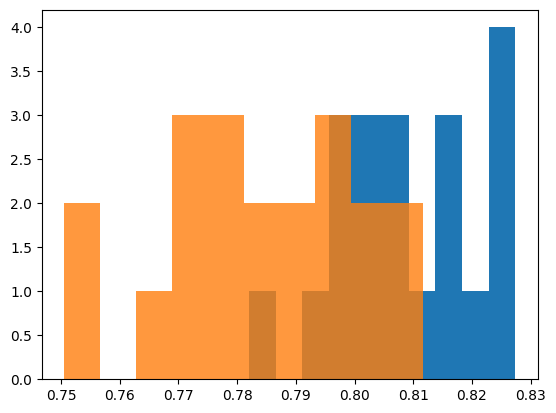

In [229]:
pylab.hist(result_random_forest_class), pylab.hist(result_logistic_reg, alpha=0.8) # Azul é o RandonForest

<Axes: >

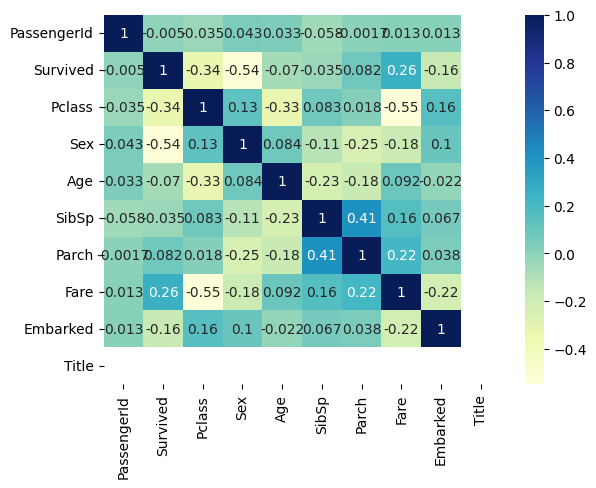

In [230]:
sns.heatmap(train.corr(), annot=True, cmap='YlGnBu')

In [231]:
# Criar arquivo para submissão no Kaggle
sub_predict1 = model_logistic_reg.predict(test)
sub_predict2 = model_random_forest_class.predict(test)

final = test.copy()
final['Survived'] = sub_predict1
final[['PassengerId', 'Survived']].to_csv('Titanic_V008.csv', index=False)
!head -n10 Titanic_V008.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [232]:

# display(v_train)
# display(v_train[train['Survived'] == 1])
# display(train[train['Embarked'].isnull()])
# display(train[train['Name'].str.contains('Col')])